In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
import ngmix
import galsim
import functools

import proplot as plot

In [90]:
from ngmix.prepsfmom.gaussmom import _deconv_galsim, _zero_pad_image

def _comput_shift_fft(xoff, yoff, dim):
    f = np.fft.fftfreq(dim)
    fx = f.reshape(1, -1)
    fy = f.reshape(-1, 1)
    kcen = 2.0 * np.pi * (fy * yoff + fx * xoff)
    return np.cos(kcen) - 1j*np.sin(kcen)

def _deconv_wiener(obs, psf_obs, pad_factor=4, reg=3):
    # pick the larger size
    if obs.image.shape[0] > psf_obs.image.shape[0]:
        target_dim = int(obs.image.shape[0] * pad_factor)
    else:
        target_dim = int(psf_obs.image.shape[0] * pad_factor)

    # pad the image and weight
    # compute new profile center
    im, im_pad_offset, im_pad_offset_end = _zero_pad_image(obs.image.copy(), target_dim)
    jac = obs.jacobian
    im_row0 = jac.row0 + im_pad_offset
    im_col0 = jac.col0 + im_pad_offset
    
    # if we have a PSF, we pad and get the offset of the PSF center from
    # the object center. this offset gets removed in the FFT so that objects
    # stay in the same spot.
    # We assume the Jacobian is centered at the object/PSF center.
    psf_im, psf_pad_offset, _ = _zero_pad_image(
        psf_obs.image.copy(), target_dim
    )
    psf_row0 = psf_obs.jacobian.row0 + psf_pad_offset
    psf_col0 = psf_obs.jacobian.col0 + psf_pad_offset
    psf_row_offset = psf_row0 - im_row0
    psf_col_offset = psf_col0 - im_col0
    
    # do the deconv
    imfft = np.fft.fftn(im)
    psf_imfft = np.fft.fftn(psf_im)
    
    med_wgt = np.median(obs.weight)
    wgt = obs.weight.copy()
    wgt[wgt == 0] = med_wgt
    nf = np.sum(1/wgt)
    sf = np.abs(imfft)**2
    g = (np.conj(psf_imfft) * sf) / (np.abs(psf_imfft)**2 * sf + reg*nf)

    imfft *= g

    # remove position shifts
    imfft *= _comput_shift_fft(psf_col_offset, psf_row_offset, psf_im.shape[0])
    imfft *= _comput_shift_fft(im_col0, im_row0, im.shape[0])

    im_rev = np.fft.ifftn(imfft)

    deconv_obs = ngmix.Observation(
        image=im_rev[
            im_pad_offset:im_rev.shape[0]-im_pad_offset_end, 
            im_pad_offset:im_rev.shape[1]-im_pad_offset_end
        ].real,
        weight=obs.weight.copy(),
        jacobian=obs.jacobian,
    )
    return deconv_obs

In [91]:
def gen_data(nse_fac):
    rng = np.random.RandomState()

    fwhm = 1.6
    psf_fwhm = 0.9
    image_size = 48
    cen = (image_size - 1)/2
    gs_wcs = galsim.ShearWCS(
        0.25, galsim.Shear(g1=-0, g2=0)).jacobian()
    psf_off = (1.5, -0.75)

    gal = galsim.Exponential(
        half_light_radius=fwhm,
    ).shear(
        g1=-0.1, g2=0.1
    ).withFlux(
        400)
    psf = galsim.Gaussian(
        fwhm=psf_fwhm
    ).shear(
        g1=0.3, g2=-0.15
    )
    im = galsim.Convolve([gal, psf]).drawImage(
        nx=image_size,
        ny=image_size,
        wcs=gs_wcs).array
    im_true = gal.drawImage(
        nx=image_size,
        ny=image_size,
        wcs=gs_wcs,
        method='no_pixel').array

    noise = np.sqrt(np.sum(im**2)) / nse_fac
    im += np.random.normal(scale=noise, size=im.shape)

    wgt = np.ones_like(im) / noise**2
    scale = np.sqrt(gs_wcs.pixelArea())

    psf_im = psf.drawImage(
        nx=image_size,
        ny=image_size,
        wcs=gs_wcs,
        offset=psf_off).array

    obs = ngmix.Observation(
        image=im,
        jacobian=ngmix.Jacobian(row=cen, col=cen, wcs=gs_wcs),
        weight=wgt,
    )

    psf_obs = ngmix.Observation(
        image=psf_im,
        jacobian=ngmix.Jacobian(row=cen+psf_off[1], col=cen+psf_off[0], wcs=gs_wcs)
    )
    return obs, psf_obs, im_true, im

-34745.62393100891 7.275957614183426e-12 -4830377772198343.0
-34745.6239310089


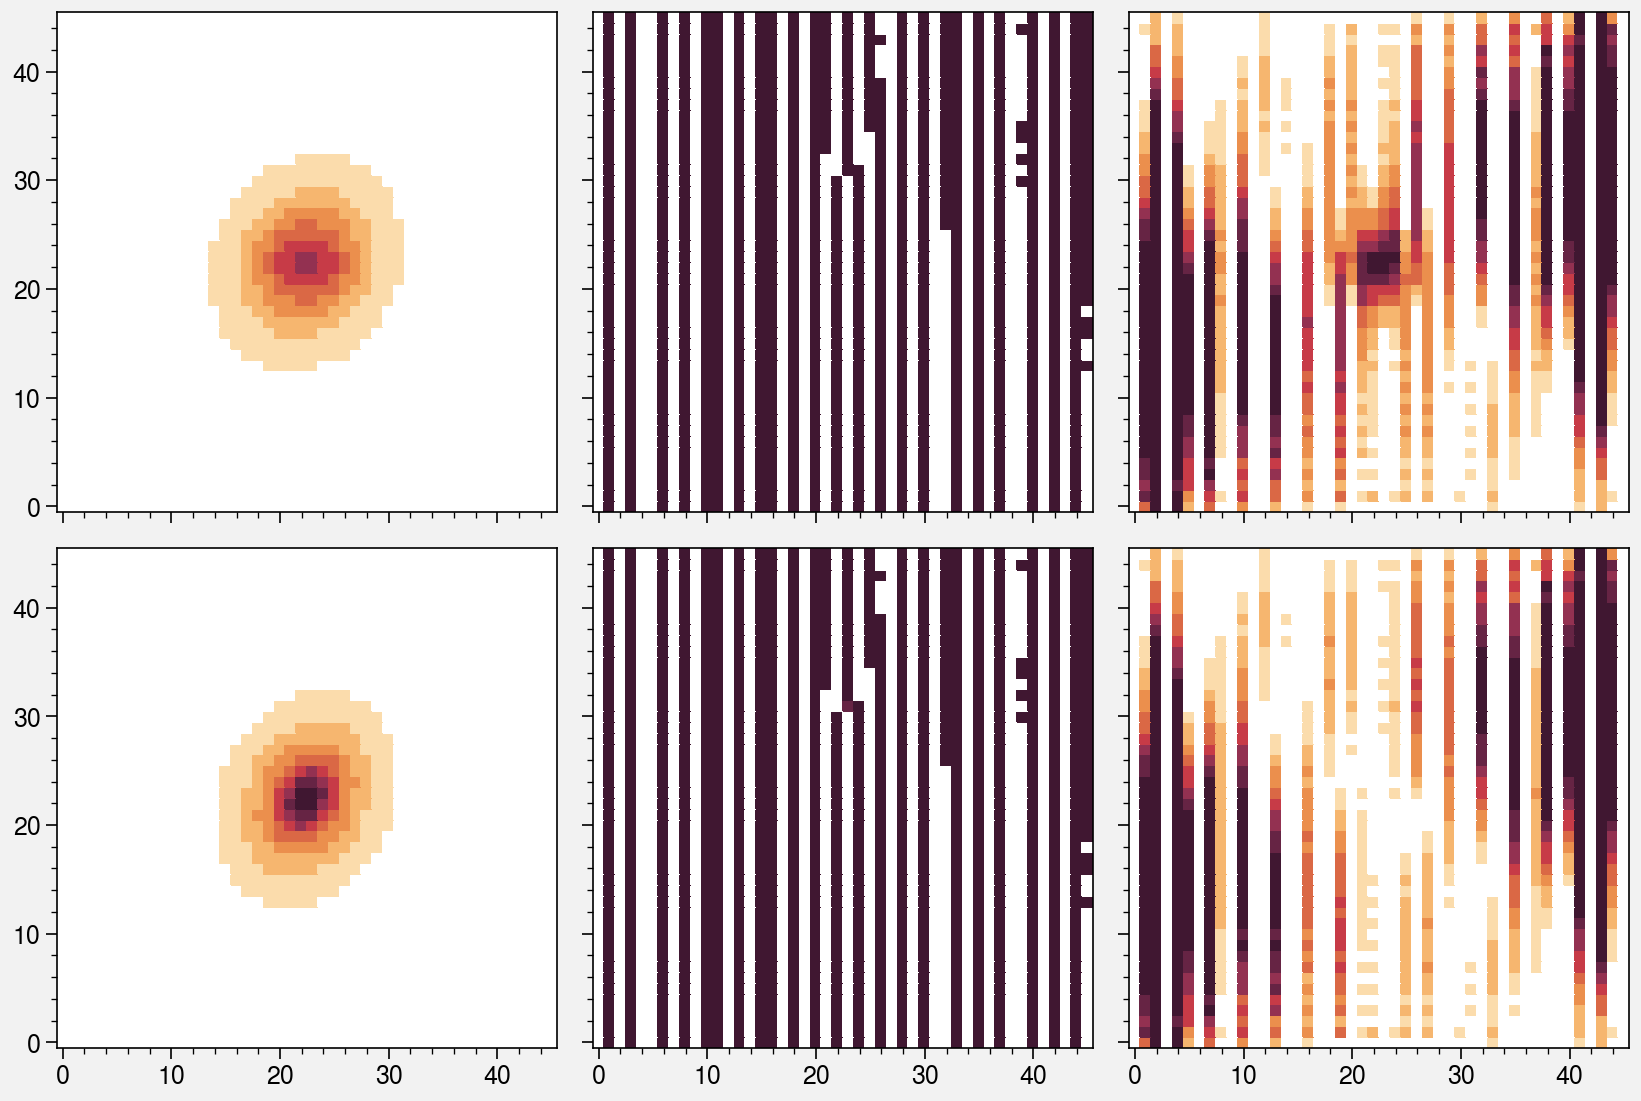

In [95]:
vals = []
for _ in range(100):
    obs, psf_obs, im_true, im = gen_data(1e20)
    c_obs = _deconv_custom(obs, psf_obs)
    # gs_obs = _deconv_galsim(obs, psf_obs)
    vals.append(c_obs.image.sum())
print(np.mean(vals), np.std(vals), (np.mean(vals)-400)/np.std(vals))

gs_obs = _deconv_galsim(obs, psf_obs)
c_obs = _deconv_custom(obs, psf_obs)
print(np.sum(c_obs.image))

vmax = np.max(im_true)
vmin = 0

cut = 1
fig, axs = plot.subplots(nrows=2, ncols=3)
axs[0, 0].pcolormesh(im[cut:-cut, cut:-cut], vmax=vmax, vmin=vmin)
axs[0, 1].pcolormesh(c_obs.image[cut:-cut, cut:-cut], vmax=vmax, vmin=vmin)
axs[1, 0].pcolormesh(im_true[cut:-cut, cut:-cut], vmax=vmax, vmin=vmin)
axs[1, 1].pcolormesh(c_obs.image[cut:-cut, cut:-cut] - im_true[cut:-cut, cut:-cut], vmax=vmax, vmin=vmin)
axs[0, 2].pcolormesh(gs_obs.image[cut:-cut, cut:-cut], vmax=vmax, vmin=vmin)
axs[1, 2].pcolormesh(gs_obs.image[cut:-cut, cut:-cut].real - im_true[cut:-cut, cut:-cut], vmax=vmax, vmin=vmin)

In [ ]:
noise = 1e-3
nse = np.random.normal(size=(101, 101), scale=noise)
pf = 4
pad_nse, _, _ = _zero_pad_image(nse, 101*pf)

print(np.sqrt(np.mean(np.abs(np.fft.fftn(pad_nse))**2)), noise * np.sqrt(np.prod(pad_nse.shape)))


In [ ]:
def _comput_shift_fft(xoff, yoff, dim):
    f = np.fft.fftfreq(dim)
    fx = f.reshape(1, -1)
    fy = f.reshape(-1, 1)
    kcen = 2.0 * np.pi * (fy * yoff + fx * xoff)
    return np.cos(kcen) - 1j*np.sin(kcen)

imfft = np.fft.fftn(im)
psf_imfft = np.fft.fftn(psf_im)

noise_floor = 3*np.sqrt(np.sum(1/wgt))
print(noise_floor)
zero_msk = (
    (np.abs(psf_imfft) < 1e-3)
    |(np.abs(imfft) < noise_floor)
)

if np.any(psf_zero_msk):
    # rang = np.random.uniform(size=psf_imfft.shape, low=0, high=2.0*np.pi)
    psf_imfft[zero_msk] = 1. # 1e-3*(np.cos(rang) + 1j * np.sin(rang))[zero_msk]
#     imfft[zero_msk] *= psf_imfft[zero_msk]
#     imfft[zero_msk] = (
#         rng.normal(size=imfft.shape, scale=noise/np.sqrt(2)) 
#         + 1j * rng.normal(size=imfft.shape, scale=noise/np.sqrt(2))
#     )[zero_msk]

imfft /= psf_imfft

imfft *= _comput_shift_fft(psf_off[0], psf_off[1], im.shape[0])
imfft *= _comput_shift_fft(cen, cen, im.shape[0])

im_rev = np.fft.ifftn(imfft)
print(np.sum(im_rev), np.sum(deconv_obs.image))

vmax = np.max(im_true)
vmin = 0

cut = 1
fig, axs = plot.subplots(nrows=2, ncols=3)
axs[0, 0].pcolormesh(im[cut:-cut, cut:-cut], vmax=vmax, vmin=vmin)
axs[0, 1].pcolormesh(im_rev[cut:-cut, cut:-cut].real, vmax=vmax, vmin=vmin)
axs[1, 0].pcolormesh(im_true[cut:-cut, cut:-cut], vmax=vmax, vmin=vmin)
axs[1, 1].pcolormesh(im_rev[cut:-cut, cut:-cut].real - im_true[cut:-cut, cut:-cut], vmax=vmax, vmin=vmin)

axs[0, 2].pcolormesh(deconv_obs.image[cut:-cut, cut:-cut], vmax=vmax, vmin=vmin)
axs[1, 2].pcolormesh(deconv_obs.image[cut:-cut, cut:-cut].real - im_true[cut:-cut, cut:-cut], vmax=vmax, vmin=vmin)

In [ ]:
f = np.fft.fftfreq(im.shape[0])

_cen = cen+1
fx = f.reshape(1, -1)
fy = f.reshape(-1, 1)
kcen = 2.0 * np.pi * (fy*_cen + fx*_cen)
cen_phase = np.cos(kcen) + 1j*np.sin(kcen)
# do it once profile and once for the kernel

imfft = np.fft.fftn(im)
imfft *= cen_phase

psf_imfft = np.fft.fftn(psf_im)
kcen = 2.0 * np.pi * (fy*psf_off[1] + fx*psf_off[0])
cen_phase = np.cos(kcen) + 1j*np.sin(kcen)
psf_imfft *= cen_phase

psf_zero_msk = np.abs(psf_imfft) < 1e-3 * np.max(np.abs(psf_imfft))
if np.any(psf_zero_msk):
    psf_imfft[psf_zero_msk] = 1.0
    imfft[psf_zero_msk] = 0.0

imfft /= psf_imfft

im_rev = np.fft.ifftn(imfft)

print(np.sum(im_rev))

In [ ]:
cut = 1
fig, axs = plot.subplots(nrows=1, ncols=3)
axs[0].pcolormesh(im_rev[cut:-cut, cut:-cut].real)
axs[1].pcolormesh(im_true[cut:-cut, cut:-cut])
axs[2].pcolormesh(im_rev[cut:-cut, cut:-cut].real - im_true[cut:-cut, cut:-cut])
(
    np.unravel_index(np.argmax(im_rev.real), im_rev.real.shape), np.sum(im_rev.real == np.max(im_rev.real)), 
    np.unravel_index(np.argmax(im_true), im_true.shape), np.sum(im_true == np.max(im_true)),
    np.max(im_true), np.max(im_rev.real),
)

In [ ]:
np.max(np.abs(im_rev.real)), np.min(np.abs(im_rev.real))

In [ ]:
scale = 0.263
dim = 128
cen = (dim-1)/2
jac = ngmix.DiagonalJacobian(scale=scale, row=cen+1.5, col=cen-1.2)

g = ngmix.GMixModel([0, 0, -0.1, 0.1, ngmix.moments.fwhm_to_T(ngmix.moments.sigma_to_fwhm(1)), 1], "gauss")
im_cen = g.make_image((dim, dim), jacobian=jac)

obs = ngmix.Observation(
    image=im_cen,
    jacobian=jac,
    weight=np.ones_like(im_cen) * 0 + 1e8,
)

In [ ]:
%%time

ppmom = ngmix.gaussmom.GaussMom(fwhm=1.2)
res_gm = ppmom.go(obs)

In [ ]:
%%time

ppmom = ngmix.prepsfmom.PrePSFGaussMom(fwhm=1.2)
res_ppm = ppmom.go(obs, return_kernels=True)

In [ ]:
# # ppmom = ngmix.prepsfmom.PrePSFMom(pad_factor=1)
# # res = ppmom.go(obs)
# # print(res["flux"], res["T"], res["g1"], res["g2"])

print(res_gm["flux"], res_gm["T"], res_gm["e"][0], res_gm["e"][1])
print(res_ppm["flux"], res_ppm["T"], res_ppm["e1"], res_ppm["e2"])

In [ ]:
res_ppm

In [ ]:
np.linalg.eigvals(res_ppm["mom_cov"])

In [ ]:
imfft = np.fft.fftn(im)
im_rev = np.fft.ifftn(imfft * res["kernels"][4])

print(np.fft.ifftn(imfft * res["kernels"][4])[0, 0])


print(np.unravel_index(np.argmax(im_rev, axis=None), im_rev.shape))

fig, axs = plot.subplots()
axs.pcolormesh(im_rev.real)

In [ ]:
im

In [ ]:
fig, axs = plot.subplots(nrows=1, ncols=2)
axs[0].imshow(res["kernels"][0], cmap='rocket')
axs[1].imshow(res["im"], cmap='rocket')

k0 = res["kernels"][0]
im = res["im"]

k = res["kernels"][1]
print("uu:", np.sum(im * k) / np.sum(im * k0), res["uu"])

k = res["kernels"][2]
print("uv:", np.sum(im * k) / np.sum(im * k0), res["uv"])

k = res["kernels"][3]
print("vv:", np.sum(im * k) / np.sum(im * k0), res["vv"])

In [ ]:
(res["uu"] - res["vv"] ) /(res["uu"] + res["vv"]), (2*res["uv"]) /(res["uu"] + res["vv"]), res["e1"], res["e2"]

In [ ]:
np.sum(im * k0)

In [ ]:
res["flux"], res["vv"]

In [ ]:
@functools.lru_cache(maxsize=1024)
def build_kernel_cache(dim, sigma, scale):
    cen = (dim-1) / 2
    x, y = np.meshgrid(np.arange(dim), np.arange(dim))
    x = x.astype(np.float64)
    y = y.astype(np.float64)
    y -= cen
    x -= cen
    x *= scale
    y *= scale

    r2 = x**2 + y**2

    h = sigma
    sc2 = h**2

    z = np.sqrt(r2/sc2)
    msk = z < 3
    kf = np.zeros((dim, dim))
    kf[msk] = 35 / 96 * (1 - (z[msk] / 3) ** 2) ** 3 / h
    
    kxx = kf * x**2
    kyy = kf * y**2
    kxy = kf * x*y
    
    nrm = np.sum(kf)
    
    return {
        "rkxx": kxx / nrm,
        "rkyy": kyy / nrm,
        "rkxy": kxy / nrm,
        "rkf": kf / nrm,
        "fkxx": np.fft.fftn(kxx / nrm),
        "fkyy": np.fft.fftn(kyy / nrm),
        "fkxy": np.fft.fftn(kxy / nrm),
        "fkf": np.fft.fftn(kf / nrm),
        "scale": scale,
        "dim": dim,
        "sigma": sigma,
        "cen": cen,
    }

In [ ]:
def measure_kernels(im, kernels, offset=None, wgt=None):
    rnrm = np.sum(im * kernels["rkf"])
    rxx = np.sum(im * kernels["rkxx"]) / rnrm
    ryy = np.sum(im * kernels["rkyy"]) / rnrm
    rxy = np.sum(im * kernels["rkxy"]) / rnrm

    imfft = np.fft.fftn(im) * kernels["scale"]**2
    f = np.fft.fftfreq(kernels["dim"], d=kernels["scale"])
    if offset is not None:
        xcen = offset[0]
        ycen = offset[1]
        fx = f.reshape(1, -1)
        fy = f.reshape(-1, 1)
        kcen = 2.0 * np.pi * (fy*ycen + fx*xcen)
        cen_phase = np.cos(kcen) - 1j*np.sin(kcen)
        imfft *= cen_phase
    
    df = f[1] - f[0]
    fnrm = np.sum(imfft * kernels["fkf"])
    fxx = np.sum(imfft * kernels["fkxx"]) / fnrm
    fyy = np.sum(imfft * kernels["fkyy"]) / fnrm
    fxy = np.sum(imfft * kernels["fkxy"]) / fnrm
    
    if wgt is not None:
        print("real std:", np.sqrt(np.sum(1/wgt * kernels["rkf"]**2)))
        tot_var = np.sum(np.ones_like(im) /wgt)
        print(
            "fourier std:", (
                np.sqrt(np.sum(tot_var * kernels["fkf"]*kernels["fkf"])).real 
                * kernels["scale"]**2 
                * df**2
            ),
        )

    return (
        (rnrm, rxx + ryy, (rxx - ryy) / (rxx + ryy), 2 * rxy / (rxx + ryy)),
        ((fnrm * df**2).real, (fxx + fyy).real, ((fxx - fyy) / (fxx + fyy)).real, (2 * fxy / (fxx + fyy)).real),
        (fnrm * df**2, fxx + fyy, (fxx - fyy) / (fxx + fyy), 2 * fxy / (fxx + fyy))
    )

In [ ]:
offset = np.array([1.2121, -1.2345])
g = ngmix.GMixModel([
    offset[0], offset[1], 
    -0.1, 0.1, 
    ngmix.moments.fwhm_to_T(ngmix.moments.sigma_to_fwhm(1)), 
    1], "gauss")

dim = 53
scale = 0.15
cen = (dim-1)/2
jac = ngmix.DiagonalJacobian(scale=scale, row=cen, col=cen)
im = g.make_image((dim, dim), jacobian=jac)

g = ngmix.GMixModel([0, 0, -0.1, 0.1, ngmix.moments.fwhm_to_T(ngmix.moments.sigma_to_fwhm(1)), 1], "gauss")
im_cen = g.make_image((dim, dim), jacobian=ngmix.DiagonalJacobian(scale=scale, row=cen, col=cen))

In [ ]:
fig, axs = plot.subplots()
axs.imshow(im, cmap='rocket')

In [ ]:
%%time

kernels = build_kernel_cache(dim, 0.55, scale)

In [ ]:
wgt = 1e6
nse = np.random.RandomState().normal(size=im.shape) * np.sqrt(1/wgt)

kernels = build_kernel_cache(dim, 0.55, scale)
print(measure_kernels(im_cen + nse, kernels, offset=(0, 0), wgt=wgt)[0])

kernels = build_kernel_cache(dim, 0.55, scale)
print(measure_kernels(im, kernels, offset=offset)[1])

In [ ]:
vals = []
for _ in range(1000):
    nse = np.random.RandomState().normal(size=im.shape) * np.sqrt(1/wgt)

    kernels = build_kernel_cache(dim, 0.55, scale)
    vals.append(measure_kernels(im_cen + nse, kernels, offset=(0, 0))[1][0])

print(np.std(vals))

In [ ]:
gal = galsim.Exponential(half_light_radius=0.5)
psf = galsim.Gaussian(fwhm=0.9)
obj = galsim.Convolve(gal, psf)

In [ ]:
im = obj.drawImage(scale=0.2)
psf_im = psf.drawImage(scale=0.2)

In [ ]:
gim = galsim.InterpolatedImage(im, scale=0.2)
gpsf_im = galsim.InterpolatedImage(psf_im, scale=0.2)

In [ ]:
x, y = np.meshgrid(np.arange(dim), np.arange(dim))
x = x.astype(np.float64)
y = y.astype(np.float64)
y -= cen
x -= cen
x *= 0.2
y *= 0.2

r2 = x**2 + y**2

h = 0.55
sc2 = h**2

z = np.sqrt(r2/sc2)
msk = z < 3
wf = np.zeros_like(x)

wf[msk] = 35 / 96 * (1 - (z[msk] / 3) ** 2) ** 3 / h

fig, axs = plot.subplots()
axs.imshow(wf, cmap='rocket')

In [ ]:
gwf = galsim.InterpolatedImage(galsim.ImageF(wf), scale=0.2, )

In [ ]:
fobj = galsim.Convolve([galsim.Deconvolve(gpsf_im), gim, gwf])

In [ ]:
fig, axs = plot.subplots()
axs.imshow(fobj.drawImage(method='no_pixel').array, cmap='rocket')



In [ ]:
def wfun_ksigma(k, scale=1.2, n=4):
    sc = np.sqrt(2 * n)/scale
    msk = k < sc
    wk = np.zeros_like(k)
    wk[msk] = np.power(1.0 - k[msk]*k[msk]/sc/sc, n)
    return wk

def wfun_unit(k):
    return np.ones_like(k)

In [ ]:
print(ngmix.moments.fwhm_to_T(ngmix.moments.sigma_to_fwhm(1)))

g = ngmix.GMixModel([0, 0, 0.1, -0.3, ngmix.moments.fwhm_to_T(ngmix.moments.sigma_to_fwhm(1)), 1], "gauss")

dim = 101
scale = 0.1
cen = (dim-1)/2
jac = ngmix.DiagonalJacobian(scale=scale, row=cen, col=cen)
im = g.make_image((dim, dim), jacobian=jac)
im += np.ones_like(im) * np.random.normal(size=im.shape) * 0

In [ ]:
fig, axs = plot.subplots()
axs.imshow(im, cmap='rocket')

In [ ]:
imfft = np.fft.fftn(im)
f = np.fft.fftfreq(im.shape[0], d=scale)

xcen = cen
ycen = cen

fx = f.reshape(1, -1)
fy = f.reshape(-1, 1)
kcen = fy*ycen + fx*xcen
cen_phase = np.cos(kcen) + 1j*np.sin(kcen)

imfft_cen = imfft * cen_phase

In [ ]:
fig, axs = plot.subplots(nrows=2, ncols=3)

axs[0, 0].imshow(np.fft.fftshift((imfft.real)), cmap='rocket')
axs[0, 1].imshow(np.fft.fftshift((imfft.imag)), cmap='rocket')
axs[0, 2].imshow(np.fft.fftshift(np.abs(imfft)), cmap='rocket')

axs[1, 0].imshow(np.fft.fftshift((imfft_cen.real)), cmap='rocket')
axs[1, 1].imshow(np.fft.fftshift((imfft_cen.imag)), cmap='rocket')
axs[1, 2].imshow(np.fft.fftshift(np.abs(imfft_cen)), cmap='rocket')

In [ ]:
kmag = np.sqrt(fx*fx + fy*fy)
wf = wfun_unit(kmag)

df = f[1]-f[0]
prof = imfft_cen
nrm = df**2 * np.sum(prof * wf)
print(
    df**2 * np.sum(prof * wf),
    df**2 * np.sum(prof * wf * (fx*fx + fy*fy)) / nrm,
    df**2 * np.sum(prof * wf * (fx*fx - fy*fy)) / nrm,
    df**2 * np.sum(prof * wf * (2*fx*fy)) / nrm,
)

In [ ]:
prof = np.abs(imfft)
nrm = np.sum(prof * wf)
mxx = np.sum(prof * wf * (fx**2)) / nrm
myy = np.sum(prof * wf * (fy**2)) / nrm
mxy = np.sum(prof * wf * (fx*fy)) / nrm

m = np.array([[mxx, mxy], [mxy, myy]])
minv = np.linalg.inv(m)

T = minv[0, 0] + minv[1, 1]
e1 = (minv[0, 0] - minv[1, 1]) / T
e2 = 2*minv[0, 1] / T

print(m, "\n", minv, "\n", T, "\n", (e1, e2), "\n", ngmix.shape.e1e2_to_g1g2(e1, e2))

In [ ]:
x, y = np.meshgrid(np.arange(dim), np.arange(dim))
x = x.astype(np.float64)
y = y.astype(np.float64)
y -= cen
x -= cen
x *= scale
y *= scale

nrm = np.sum(im) * scale**2
enrm = np.sum(im * (x*x + y*y)) * scale**2
e1 = np.sum(im * (x*x - y*y)) * scale**2 / enrm
e2 = np.sum(im * (2*x*y)) * scale**2 / enrm
print(
    nrm,
    enrm / nrm,
    e1,
    e2,
)

print(ngmix.shape.e1e2_to_g1g2(e1, e2))

In [ ]:
for x in [-15, -10, 1, 12]:
    if -20 < x < -11:
        print("yes")
    else:
        print("no")

In [ ]:
(5 < 10) is True

In [ ]:
(5 < 10 > 2 < 4 > 6)

In [ ]:
from ngmix.moments import fwhm_to_sigma

fwhm_to_sigma(1.2)